In [ ]:
import graphlab as gl
import graphlab.numpy
from datacleaner import autoclean
import pandas as pd
import numpy as np

# Load some house sales data

In [ ]:
my_data = pd.read_csv('train.csv', sep=',')
#sales = gl.SFrame('train.csv')
my_clean_data = autoclean(my_data)
my_data.to_csv('my_clean_train.csv', sep=',', index=False)

my_testdata = pd.read_csv('test.csv', sep=',')
my_clean_testdata = autoclean(my_testdata)
my_testdata.to_csv('my_clean_testdata.csv', sep=',', index=False)
predict_sales = gl.SFrame(my_testdata)

# Select only the columns which has correlations with SalePrice

In [ ]:
correlation = my_clean_data.corr()["SalePrice"]

#print correlation

my_columns = np.sort(np.where(abs(correlation) > 0.3))

myFilteredData = my_clean_data.iloc[:, my_columns.tolist()[0]]

mynewcolumns = my_clean_data.iloc[:0, my_columns.tolist()[0]]

column_string = map(str, mynewcolumns)

print myFilteredData


# If you have multiple columns in your dataframe and would like to remove all rows that have outliers in at least one column, the following expression would do that in one shot.

For each column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation. Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold. .all(axis=1) ensures that for each row, all column satisfy the constraint. Finally, result of this condition is used to index the dataframe.

So essentially I need to put a filter such that we select all rows where the values of a certain column are within 3 standard deviations from mean

In [ ]:
#r = pd.DataFrame.from_csv('my_clean_train.csv', sep=',')
#df = pd.DataFrame(myFilteredData)
from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

df = pd.DataFrame(myFilteredData, columns=column_string)
myFilteredData_without_outliers = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

#this is the filtered and outliers removed data
sales = gl.SFrame(myFilteredData_without_outliers)

# this is the original data without removing outliers and non-correlated columns
sales_ori = gl.SFrame(my_clean_data)

print sales


# Create a simple regression model of GrLivArea to SalePrice

In [16]:
train_data,test_data = sales.random_split(.8,seed=0)
train_data_ori,test_data_ori = sales_ori.random_split(.8,seed=0)

# Build the regression model

In [17]:
GrLivArea_model = gl.linear_regression.create(train_data, target='SalePrice', features=['GrLivArea'])

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 980

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.001002     | 225483.001027      | 105231.359488        | 43320.408328  | 39497.424582    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# Evaluate the simple model

This shows the mean SalePrice

In [18]:
print test_data['SalePrice'].mean()

165601.401487


"Max_error" means the outliers (USD500k is the outlier) and RMSE is the "Root Mean Square Error"

In [19]:
print GrLivArea_model.evaluate(test_data)

{'max_error': 171492.86081170558, 'rmse': 40392.34134310533}


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

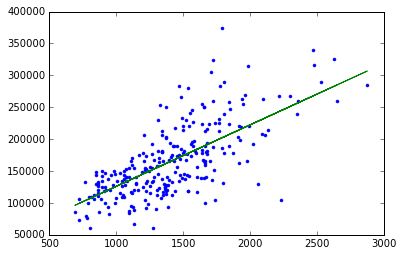

In [48]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], GrLivArea_model.predict(test_data), '-')

In [11]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,32041.8543111,4853.69547898
GrLivArea,None,94.6375164705,3.21040742958


The summary from table above is the value of y intercept is USD23490 and average price for GrLivArea is USD100 per sqf

# Create a new multi features model (Original)

In [20]:
my_features_model_ori = gl.linear_regression.create(train_data_ori,target='SalePrice')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1091

Number of features          : 80

Number of unpacked features : 80

Number of coefficients    : 81

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.016010     | 311369.713895      | 132821.364580        | 30646.484621  | 31790.040847    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# Create a new multi features model (After removing non-correlated columns)

In [50]:
my_features_model = gl.linear_regression.create(train_data,target='SalePrice')


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 971

Number of features          : 25

Number of unpacked features : 25

Number of coefficients    : 26

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.052538     | 160787.574648      | 85153.684204         | 21874.455196  | 25138.891524    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [43]:
print column_string

['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


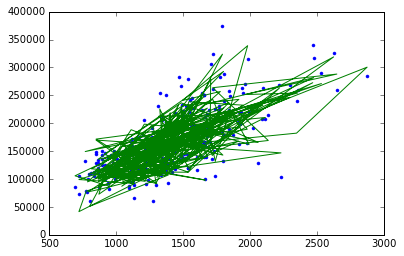

In [51]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], my_features_model.predict(test_data), '-')

In [52]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,29600.0848541,4821.3316518
GrLivArea,None,96.4883115704,3.18689472425


In [53]:
my_features_model.get('coefficients')

name,index,value,stderr
(intercept),None,-584982.270219,127903.212298
LotFrontage,None,229.347895783,46.0990797246
OverallQual,None,10670.7466366,984.409492782
YearBuilt,None,147.784577949,55.2928501714
YearRemodAdd,None,222.200181395,50.5193118504
MasVnrArea,None,5.79634271852,6.06408658828
ExterQual,None,-1388.35529426,2210.50820309
Foundation,None,2421.42506172,1576.19481282
BsmtQual,None,-5035.84053206,1249.91239417
BsmtFinSF1,None,20.5603805476,2.07671397333


# Result before removing outliers
{'max_error': 263715.68381302676, 'rmse': 53423.71497179019}
{'max_error': 200848.92346621933, 'rmse': 34190.02483489307}

# Result After removing outliers 
Root Mean Square Error has reduced from 34190 to 22094

In [54]:
print GrLivArea_model.evaluate(test_data)

#result before selecting correlated columns and removing outliers
print my_features_model_ori.evaluate(test_data)

#result after selecting correlated columns
print my_features_model.evaluate(test_data)

print test_data

{'max_error': 171492.86081170558, 'rmse': 40392.34134310533}
{'max_error': 99236.82287140639, 'rmse': 25839.37708821685}
{'max_error': 72807.63521825697, 'rmse': 22017.260612776357}
+-------------+-------------+-----------+--------------+------------+-----------+
| LotFrontage | OverallQual | YearBuilt | YearRemodAdd | MasVnrArea | ExterQual |
+-------------+-------------+-----------+--------------+------------+-----------+
|     69.0    |      6      |    1960   |     1960     |   212.0    |     3     |
|     72.0    |      4      |    1967   |     1967     |    0.0     |     3     |
|     98.0    |      8      |    2007   |     2008     |   200.0    |     2     |
|     70.0    |      5      |    1959   |     1959     |    0.0     |     3     |
|     68.0    |      5      |    1953   |     2007     |    0.0     |     3     |
|     70.0    |      5      |    1959   |     1959     |    0.0     |     3     |
|     84.0    |      8      |    2006   |     2006     |    0.0     |     2     

# Apply learned models to predict  prices of house

In [55]:
house1 = gl.SFrame(predict_sales)

X = house1.select_columns(['Id'])

# convert this to SArray
Y = X["Id"]

In [56]:
my_results = my_features_model.predict(house1)
#print type(my_results)
round_up = np.around(my_results, decimals=1, out=None)

sf = gl.SFrame({'Id':Y, 'SalePrice':round_up})

Z =sf["Id","SalePrice"]

print Z

+------+-----------+
|  Id  | SalePrice |
+------+-----------+
| 1461 |  124176.9 |
| 1462 |  171036.2 |
| 1463 |  186000.0 |
| 1464 |  202435.6 |
| 1465 |  189310.6 |
| 1466 |  174860.2 |
| 1467 |  186786.2 |
| 1468 |  159114.4 |
| 1469 |  204565.0 |
| 1470 |  119553.2 |
+------+-----------+
[1459 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [57]:
my_result = Z.save('predicted_houseprice.csv', format='csv')